In [258]:
# Alberto Ruiz Biestro
#A01707550

using CairoMakie
using Random
using StatsBase
using Printf
using Images
using DataFrames
using LinearAlgebra
using CSV
#using ColorSchemes
using StaticArrays
using MAT

In [303]:
function hamiltonian(mat::Matrix, J::Float64, ii::Int, jj::Int)
           
    N = size(mat,1)
      
    # los índices son raros pero es porque Julia inicia en 1
    up_i = mod(ii,N)+1
    down_i = mod(ii-1-1,N)+1
    up_j = mod(jj,N)+1
    down_j = mod(jj-1-1,N)+1
    #display((down_i,up_j))
    #display(mat[down_i,up_j])
    energy = -J * (mat[up_i,jj]+mat[ii,up_j]+mat[down_i,jj]+mat[ii,down_j]+mat[down_i,up_j]+mat[up_i,down_j])

    #energy += B_field
    return energy
    # caso e)
end

function hamiltonian_full(mat::Matrix, J::Float64)
           
    N = size(mat,1)
    energy = zeros(N,N)
    for ii in 1:N
        for jj in 1:N
                up_i = mod(ii,N)+1
                down_i = mod(ii-1-1,N)+1
                up_j = mod(jj,N)+1
                down_j = mod(jj-1-1,N)+1

                energy = -J * (mat[up_i,jj]+mat[ii,up_j]+mat[down_i,jj]+mat[ii,down_j]+mat[down_i,up_j]+mat[up_i,down_j])
        end
    end
    #energy += B_field
    return sum(energy)
end

function slow_temp(temp::Float64, beta::Float64)
    return temp / (1 + beta * temp)
end

function get_spin(n_experiments::Int, n::Int, temp0::Float64)
    #println("a")
    rng = MersenneTwister(1234)
    kB = 1.
    #J = -1.
    J = 1.
    # 
    #temp_vector = zeros(n_experiments)
    #temp_vector[1] = temp0
    #energy_vector = zeros(n_experiments)
    # magnetización: valor promedio de spins
    #magnet_vector = zeros(n_experiments)
          
    # constantes
    eta = 0.0001    
    final_t = 0.
    alpha = 0.2
    # vector estático
    #expdata = @SVector [1, exp(-4/(temp)), exp(-8/(temp))]
        
    spin = zeros(Int64, n, n, 2) #inicio y fin
    spin[:,:,1] = rand(rng, [-1,1], (n, n))
    matrix = spin[:,:,1]
    #energy_vector[1] = hamiltonian_full(matrix, temp0, B)
    #magnet_vector[1] = mean(matrix)
    for ii in 1:n_experiments - 1

        idx = rand(1:n)
        idy = rand(1:n)

        delta_energy = -2 * hamiltonian(matrix, J,idx, idy) * matrix[idx, idy]
        exp_index = Int(div(abs(delta_energy), 4)) + 1
        
        state = matrix[idx, idy]

        if delta_energy < 0
            state *= -1
            #energy_vector[ii + 1] = energy_vector[ii] + delta_energy
            

        elseif rand() < exp(-delta_energy/(temp0))
            state *= -1
        end

        matrix[idx, idy] = state
        #energy_vector[ii + 1] = energy_vector[ii] + state*delta_energy/2#hamiltonian_full(matrix, J, B)
        #@printf("E: %f \t", energy_vector[ii])
        #@printf("dE: %f \n", state*delta_energy)
        # función de temperatura
        # quitar para metropolis
        #temp_vector[ii + 1] = slow_temp(temp_vector[ii], eta)
        #temp_vector[ii + 1] = temp_vector[ii]# para recocido simulado: slow_temp(temp_vector[ii], eta)
        # para la energía no hay que calcular toda otra vez, simplemente restamos
        # del valor inicial ΔE
        #magnet_vector[ii + 1] = mean(matrix)
    end
    spin[:,:,2] = matrix
    return spin
end

get_spin (generic function with 2 methods)

In [299]:
@time begin
    # no tenga miedo de correrlo con 1_000_000 iteraciones
    iterations = 100_000
    dim = 100
    
    T = [1.5, 2.3, 3.0]
    # tarda un buen rato porque hay que guardar
    # los arreglos
    spin_15_0 = get_spin(iterations,dim, T[1])
    spin_23_0 = get_spin(iterations,dim, T[2]);
    spin_30_0 = get_spin(iterations,dim, T[3]);
end;

  0.019552 seconds (64 allocations: 1.023 MiB)


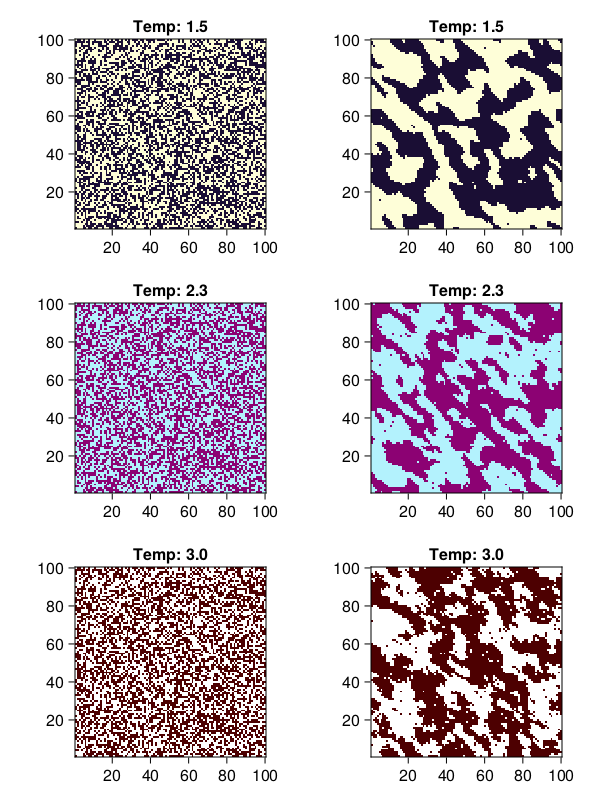

In [300]:
fig = Makie.Figure(resolution=(600, 800), title="Hamiltoniano con Signo Opuesto")

ax1 = [Makie.Axis(fig[ii,jj],  title = "Temp: "*string(T[ii])) for ii in 1:3, jj in 1:2]
heatmap!(ax1[1,1], spin_15_0[:,:,1], colormap=:tokyo)
heatmap!(ax1[1,2], spin_15_0[:,:,2], colormap=:tokyo)
heatmap!(ax1[2,1], spin_23_0[:,:,1], colormap=:hawaii)
heatmap!(ax1[2,2], spin_23_0[:,:,2], colormap=:hawaii)
heatmap!(ax1[3,1], spin_30_0[:,:,1], colormap=Reverse(:bilbao))
heatmap!(ax1[3,2], spin_30_0[:,:,2], colormap=Reverse(:bilbao))

[ax1[ii, jj].aspect = DataAspect() for ii in 1:3, jj in 1:2]

fig

# cr

In [378]:
matwrite(
    "test.mat",
    Dict("x" => [(spin_15_0, idx = "ising_15"),
                 (spin_23_0, idx = "ising_23"),
                 (spin_30_0, idx = "ising_30")])
)

In [302]:
file = matopen("ising_1.mat", "w")
write(file, "ising", spin_15_0)
close(file)

file = matopen("ising_2.mat", "w")
write(file, "ising", spin_23_0)
close(file)

file = matopen("ising_3.mat", "w")
write(file, "ising", spin_30_0)
close(file)

NO CORRER LO DE ABAJO, pruebas y erorres

In [376]:
mat = spin_15_0[:,:,1]
idx = 1:size(mat, 1)
idy = 1:size(mat, 2)

idmat = *(idx, idy')
pair_indices = idmat[2,:] # n_divisible_indices = idmat[n,:]
X = copy(idmat);
Y = copy(idmat);
X = convert(Matrix{Float64}, X);
# intercalar pedazos
[X[ii,:] = idmat[ii,:] .+ 0.5 for ii in pair_indices[1:div(end,2)]];
#M = [X Y];

In [355]:
f = Figure()

a = Makie.Axis(f[1,1])
scatter!(a, M[1])
f

LoadError: `Makie.convert_arguments` for the plot type Scatter{Tuple{Float64}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Float64

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://makie.juliaplots.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


In [309]:
mesh

100×100 Matrix{Float64}:
   1.0    2.0    3.0    4.0    5.0    6.0  …    97.0    98.0    99.0    100.0
   2.0    4.0    6.0    8.0   10.0   12.0      194.0   196.0   198.0    200.0
   3.0    6.0    9.0   12.0   15.0   18.0      291.0   294.0   297.0    300.0
   4.0    8.0   12.0   16.0   20.0   24.0      388.0   392.0   396.0    400.0
   5.0   10.0   15.0   20.0   25.0   30.0      485.0   490.0   495.0    500.0
   6.0   12.0   18.0   24.0   30.0   36.0  …   582.0   588.0   594.0    600.0
   7.0   14.0   21.0   28.0   35.0   42.0      679.0   686.0   693.0    700.0
   8.0   16.0   24.0   32.0   40.0   48.0      776.0   784.0   792.0    800.0
   9.0   18.0   27.0   36.0   45.0   54.0      873.0   882.0   891.0    900.0
  10.0   20.0   30.0   40.0   50.0   60.0      970.0   980.0   990.0   1000.0
  11.0   22.0   33.0   44.0   55.0   66.0  …  1067.0  1078.0  1089.0   1100.0
  12.0   24.0   36.0   48.0   60.0   72.0     1164.0  1176.0  1188.0   1200.0
  13.0   26.0   39.0   52.0   65.0   78